In [1]:
import pandas as pd

# Load the Excel file
cols = ["보압시간", "사출속도1~4", "보압1~2"]
level_col_name = "변수 수준"
file_path = r"./data/사출 실험계획표 27.xlsx"


excel_data = pd.read_excel(file_path)[[level_col_name] + cols]
# # find the index of the first NaN value
null_idx = excel_data.index[excel_data.iloc[:, 0].isna()].tolist()[0]

# Display the first few rows of the dataframe to understand its structure
level_table = excel_data.iloc[:null_idx, :].copy()
data_table = (
    excel_data[cols].iloc[null_idx + 2:, :].copy().reset_index(drop=True)
)
levels = level_table[level_col_name].tolist()

# Display the first few rows of the dataframe to understand its structure
assert data_table.shape[1] == len(
    cols
), "The number of columns is not correct"
print(f"Levels: {levels}")
print(f"Data table shape: {data_table.shape}")
level_table.head()

Levels: [-1, 0, 1]
Data table shape: (27, 3)


,변수 수준,보압시간,사출속도1~4,보압1~2
0,-1,1.2,40,10
1,0,1.4,50,20
2,1,1.6,60,30


In [2]:
# Function to map actual values to level values (-1, 0, 1)
def map_to_level(value, column):
    # Find the corresponding level for the value in the specified column
    level = level_table[level_table[column] == value][level_col_name].values[
        0
    ]
    return level


# Initialize an empty DataFrame with the same shape as data_table
mapped_data = pd.DataFrame(columns=cols, index=range(len(data_table)))

# Map each column in data_table to its corresponding level
for col in cols:
    mapped_data[col] = data_table[col].apply(lambda x: map_to_level(x, col))

# Convert the DataFrame to integer type
mapped_data = mapped_data.astype(int)

# Set the index name to "Case"
mapped_data.index.name = "Case"

# Set the indices to start from 1
mapped_data.index = mapped_data.index.map(lambda x: x + 1)

# Display the first few rows of the mapped data
assert mapped_data.shape[1] == len(
    cols
), "The number of columns is not correct"
mapped_data.head()

,보압시간,사출속도1~4,보압1~2
Case,,,
1,-1,-1,-1
2,0,-1,-1
3,1,-1,-1
4,-1,-1,0
5,0,-1,0


In [3]:
from pathlib import Path
from nn.schemas import _read_ss_curves, group_ss_curves

ss_curves = group_ss_curves(_read_ss_curves(raw_data_path=Path("data")))
ss_curves["Case"] = ss_curves.index.to_series().apply(
    lambda x: int(x.split("-")[1])
)
ss_curves = pd.merge(
    ss_curves.reset_index(drop=True),
    mapped_data,
    left_on="Case",
    right_index=True,
).drop(columns=["Case"])


ss_curves.head()

,strain,stress,보압시간,사출속도1~4,보압1~2
0,"[0.00, 0.00, 0.16, 0.20, 0.22, 0.26, 0.28, 0.3...","[0.000, 0.670, 0.760, 0.850, 0.940, 1.010, 1.1...",-1,-1,-1
1,"[0.00, 0.00, 8.00, 10.00, 11.00, 13.00, 14.00,...","[0.000, 0.359, 0.423, 0.487, 0.556, 0.605, 0.6...",-1,-1,-1
2,"[0.00, 0.00, 8.00, 10.00, 11.00, 13.00, 14.00,...","[0.000, 0.290, 0.354, 0.423, 0.497, 0.572, 0.6...",-1,-1,-1
3,"[0.00, 0.00, 8.00, 9.00, 11.00, 12.00, 14.00, ...","[0.000, 0.318, 0.385, 0.456, 0.513, 0.603, 0.6...",-1,-1,-1
4,"[0.00, 0.00, 8.00, 10.00, 11.00, 13.00, 14.00,...","[0.000, 0.369, 0.446, 0.526, 0.603, 0.664, 0.7...",-1,0,-1


In [4]:
import random
from typing import Tuple
import numpy as np
from scipy.interpolate import interp1d
from nn.inference import inference
from nn.schemas import normalize_1d_sequence
from warnings import warn


def warn_if_not_almost_equal(a: float, b: float, tolerance: float = 0.5):
    if not np.isclose(a, b, atol=tolerance):
        warn(f"{a} != {b}")


def pick_random_data(
    train_inputs: np.ndarray,
    train_outputs: np.ndarray,
    n: int = 1,
) -> Tuple[np.ndarray, np.ndarray]:
    x_test, y_test = train_inputs, train_outputs
    assert isinstance(x_test, np.ndarray) and isinstance(
        y_test, np.ndarray
    ), f"{type(x_test)} & {type(y_test)}"
    assert (
        x_test.shape[0] == y_test.shape[0]
    ), f"{x_test.shape} != {y_test.shape}"
    # pick n random data points
    idx = random.sample(range(x_test.shape[0]), n)
    return x_test[idx], y_test[idx]


def make_equal_interval_data(
    ss_curves: pd.DataFrame, seq_len: int, normalize: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    interpolated_stresses = []
    interpolated_strains = []
    for _, row in ss_curves.iterrows():
        row_strain = row["strain"].astype(float)
        row_stress = row["stress"].astype(float)
        interpolated_stresses.append(
            normalize_1d_sequence(
                np.column_stack((row_strain, row_stress)),
                seq_len,
                normalize=normalize,
            )  # shape: (seq_len, 1)
        )
        if normalize:
            interpolated_strains.append(np.linspace(0, 1, seq_len))
        else:
            interpolated_strains.append(
                np.linspace(
                    row_strain.min(), row_strain.max(), seq_len
                ).tolist()
            )
    # Return equal interval strain, stress data
    return (
        np.array(interpolated_strains).reshape(-1, seq_len, 1),
        np.array(interpolated_stresses).reshape(-1, seq_len, 1),
    )


def inference_lstm(
    test_data: Tuple[np.ndarray, np.ndarray],
    model_path: str,
    tolerance: float = 0.5,
    n: int = 5,
) -> np.ndarray:
    x_test, y_test = test_data
    y_pred = inference(model_path=model_path, input_data=x_test)
    assert y_pred.shape == y_test.shape, f"{y_pred.shape} != {y_test.shape}"
    seq_len = y_pred.shape[1]

    def extract_points(y: np.ndarray):
        gap = seq_len // (n - 1)
        last_idx = seq_len - 1
        return tuple(y[0, min(i * gap, last_idx), 0] for i in range(n))

    y_pred_points = extract_points(y_pred)[1:]
    y_test_points = extract_points(y_test)[1:]
    print(f"prediction: {y_pred_points}, true: {y_test_points}")
    for yp, yt in zip(y_pred_points, y_test_points):
        warn_if_not_almost_equal(yp, yt, tolerance=tolerance)
    return y_pred


def inference_ann(
    test_data: Tuple[np.ndarray, np.ndarray],
    model_path: str,
    tolerance: float = 0.5,
) -> np.ndarray:
    x_test, y_test = test_data
    y_pred = inference(model_path, x_test)
    print(f"prediction: {y_pred}, true: {y_test}")

    # Check the predictions are within the tolerance
    strength_pred = float(y_pred[0][0])
    strength_true = float(y_test[0][0])
    warn_if_not_almost_equal(
        strength_pred, strength_true, tolerance=tolerance
    )

    elongation_pred = float(y_pred[0][1])
    elongation_true = float(y_test[0][1])
    warn_if_not_almost_equal(
        elongation_pred, elongation_true, tolerance=tolerance
    )
    return y_pred

In [5]:
import multiprocessing
from uuid import uuid4

from nn.ann import ANN
from nn.config import ANNModelConfig
from nn.dataloader import DataLoader
from nn.train import Trainer
from nn.utils.logger import ApiLogger

logger = ApiLogger(__name__)

epochs = 1000
patience = 200
batch_size = 1
print_per_epoch = 50
ann_hyper_params = {
    "n1": [50],
    "n2": [40],
    "n3": [15],
}

# Creating a DataFrame
ann_df = ss_curves.copy()


def get_max(x: np.ndarray) -> float:
    return np.max(x.astype(float))


# Calculating maximum of stress and strain for each row
ann_df["strength"] = ann_df["stress"].apply(get_max)
ann_df["elongation"] = ann_df["strain"].apply(get_max)

# Dropping the original strain and stress columns
ann_df.drop(["strain", "stress"], axis=1, inplace=True)

ann_x_data = ann_df[cols].astype(float).to_numpy()
ann_y_data = ann_df[["strength", "elongation"]].astype(float).to_numpy()

dim_out = ann_y_data.shape[1]
ann_model_config = ANNModelConfig(
    output_path=f".tmp/{uuid4().hex}",
    metrics=["mae"],
    kfold_splits=0,
    print_per_epoch=print_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    patience=patience,
    loss_funcs=["mape" for _ in range(dim_out)],
    loss_weights=[1 / dim_out for _ in range(dim_out)],
    l1_reg=None,
    l2_reg=None,
    dropout_rate=0.0,
    normalize_layer=False,
    dim_out=dim_out,
    dim_in=len(cols),
)
ann_data_loader = DataLoader(
    train_inputs=ann_x_data,
    train_outputs=ann_y_data,
    train_input_params=cols,
    train_output_params=["strength", "elongation"],
)
ann_trainer = Trainer(
    data_loader=ann_data_loader,
    model_class=ANN,
    model_name=ANN.__name__,
    model_config=ann_model_config,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=False,
)

ann_x_data.shape, ann_y_data.shape

((108, 3), (108, 2))

In [6]:
from functools import reduce
import json


num_hyper_params = reduce(
    lambda x, y: x * len(y), ann_hyper_params.values(), 1
)
ann_fstem = ""
temporary = float("inf")


for ann_fstem, phist in ann_trainer.hyper_train(ann_hyper_params):
    num_hyper_params -= 1

    json.dumps(phist["train_output"], indent=4)

    inference_ann(
        model_path=ann_fstem + ".keras",
        test_data=pick_random_data(ann_x_data, ann_y_data, n=1),
    )
    best_val_loss = min(phist["train_output"]["val_loss"])  # type: ignore
    if best_val_loss < temporary:  # type: ignore
        temporary = best_val_loss
        ann_fstem = ann_fstem

assert ann_fstem != "", "fstem is empty"
assert num_hyper_params == 0, f"{num_hyper_params} != 0"
ann_fstem

[2023-11-24 21:56:06,770] nn.train:CRITICAL - model: ANN with 1 cases
[2023-11-24 21:56:06,771] nn.train:CRITICAL - training without multiprocessing...
[2023-11-24 21:56:06,820] nn.train:INFO - Start training: ANNModelConfig(seed=777, print_per_epoch=50, output_path='.tmp/f5a770ea6e614e5f9aae6f648b947e10', metrics=['mae'], epochs=1000, batch_size=1, kfold_splits=0, patience=200, dim_in=3, dim_out=2, lr=0.001, loss_funcs=['mape', 'mape'], loss_weights=[0.5, 0.5], activation='relu', l1_reg=None, l2_reg=None, dropout_rate=0.0, normalize_layer=False, freeze_layers=[], n1=50, n2=40, n3=15)
[2023-11-24 21:56:11,023] nn.callbacks:DEBUG - [Epoch  50  ]	rmse: None	loss: 49.97044	mae: 244.36688	val_loss: 50.06152	val_mae: 240.95108
[2023-11-24 21:56:14,454] nn.callbacks:DEBUG - [Epoch  100 ]	rmse: None	loss: 14.78408	mae: 65.68723	val_loss: 11.76434	val_mae: 53.94795
[2023-11-24 21:56:17,891] nn.callbacks:DEBUG - [Epoch  150 ]	rmse: None	loss: 10.82962	mae: 45.36764	val_loss: 9.60157	val_mae: 36

1/1 [==============================] - 0s 48ms/step
prediction: [[ 12.4916935 529.94684  ]], true: [[ 12.49 554.  ]]


C:\Users\dcas\AppData\Local\Temp\ipykernel_40832\3436577254.py:12: UserWarning: 529.9468383789062 != 554.0
  warn(f"{a} != {b}")


'.tmp\\f5a770ea6e614e5f9aae6f648b947e10\\ANN_E585[N1=50][N2=40][N3=15]'

In [14]:
from functools import reduce
import json
import multiprocessing
from uuid import uuid4

from nn import lstm
from nn.config import LSTMModelConfig
from nn.dataloader import DataLoader
from nn.train import Trainer

import importlib

lstm = importlib.reload(lstm)

epochs = 1000
patience = 100
batch_size = 1
print_per_epoch = 50
seq_len = 128
lstm_hyper_params = {
    "seq_len": [seq_len],
    "num_heads": [2],
}


lstm_x_data = ss_curves[cols].astype(float).to_numpy()
_, lstm_y_data = make_equal_interval_data(ss_curves, seq_len, normalize=True)

# lstm_y_data = (
#     ss_curves[["strain", "stress"]]
#     .apply(lambda x: pd.Series(normalize_1d_sequence(x, seq_len)))
#     .to_numpy()
# )[:, :, np.newaxis]
# decoder_inputs = np.zeros_like(lstm_y_data)
# decoder_inputs[:, 1:, :] = lstm_y_data[:, :-1, :]  # Teacher forcing

assert lstm_x_data.shape[0] == lstm_y_data.shape[0], (
    f"Encoder input shape {lstm_x_data.shape} and decoder output shape {lstm_y_data.shape} "
    f"do not match"
)

lstm_model_config = LSTMModelConfig(
    output_path=f".tmp/{uuid4().hex}",
    metrics=["mse", "mae"],
    kfold_splits=0,
    print_per_epoch=print_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    patience=patience,
    loss_funcs=["mse"],
    loss_weights=[1.0],
    l1_reg=None,
    l2_reg=None,
    dropout_rate=0.0,
    normalize_layer=False,
    dim_out=1,
    ann_model_path=ann_fstem + ".keras",
    dim_in=len(cols),
)
lstm_data_loader = DataLoader(
    train_inputs=lstm_x_data,
    train_outputs=lstm_y_data,
    train_input_params=cols,
    train_output_params=["stress"],
)
lstm_trainer = Trainer(
    data_loader=lstm_data_loader,
    model_class=lstm.EmbeddingAttentionLSTMRegressor,
    model_name=lstm.EmbeddingAttentionLSTMRegressor.__name__,
    model_config=lstm_model_config,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=False,
)
lstm_x_data.shape, lstm_y_data.shape

((108, 3), (108, 128, 1))

In [15]:
num_hyper_params = reduce(
    lambda x, y: x * len(y), lstm_hyper_params.values(), 1
)

lstm_fstem = ""

for lstm_fstem, phist in lstm_trainer.hyper_train(lstm_hyper_params):
    num_hyper_params -= 1

    json.dumps(phist["train_output"], indent=4)

    inference_lstm(
        model_path=lstm_fstem + ".keras",
        test_data=pick_random_data(lstm_x_data, lstm_y_data, n=1),
    )


assert lstm_fstem != "", "fstem is empty"


assert num_hyper_params == 0, f"{num_hyper_params} != 0"
lstm_fstem

[2023-11-24 21:59:14,679] nn.train:CRITICAL - model: EmbeddingAttentionLSTMRegressor with 1 cases
[2023-11-24 21:59:14,679] nn.train:CRITICAL - training without multiprocessing...
[2023-11-24 21:59:14,765] nn.train:INFO - Start training: LSTMModelConfig(seed=777, print_per_epoch=50, output_path='.tmp/1c18c5b684c445b9adc92918b5f89d17', metrics=['mse', 'mae'], epochs=1000, batch_size=1, kfold_splits=0, patience=100, dim_in=3, dim_out=1, lr=0.001, loss_funcs=['mse'], loss_weights=[1.0], activation='relu', l1_reg=None, l2_reg=None, dropout_rate=0.0, normalize_layer=False, freeze_layers=[], seq_len=128, num_heads=2, ann_model_path='.tmp\\f5a770ea6e614e5f9aae6f648b947e10\\ANN_E585[N1=50][N2=40][N3=15].keras', state_transform_activation='tanh')


Loaded ANN model: .tmp\f5a770ea6e614e5f9aae6f648b947e10\ANN_E585[N1=50][N2=40][N3=15].keras


[2023-11-24 21:59:19,075] nn.callbacks:DEBUG - [Epoch  50  ]	rmse: 0.03769	loss: 0.00142	mse: 0.00142	mae: 0.02854	val_loss: 0.00593	val_mse: 0.00593	val_mae: 0.06502
[2023-11-24 21:59:22,740] nn.callbacks:DEBUG - [Epoch  100 ]	rmse: 0.03542	loss: 0.00125	mse: 0.00125	mae: 0.02694	val_loss: 0.00140	val_mse: 0.00140	val_mae: 0.02854
[2023-11-24 21:59:26,425] nn.callbacks:DEBUG - [Epoch  150 ]	rmse: 0.03528	loss: 0.00124	mse: 0.00124	mae: 0.02561	val_loss: 0.00111	val_mse: 0.00111	val_mae: 0.02482
[2023-11-24 21:59:30,108] nn.callbacks:DEBUG - [Epoch  200 ]	rmse: 0.03248	loss: 0.00106	mse: 0.00106	mae: 0.02250	val_loss: 0.00097	val_mse: 0.00097	val_mae: 0.02599
[2023-11-24 21:59:33,741] nn.callbacks:DEBUG - [Epoch  250 ]	rmse: 0.02931	loss: 0.00086	mse: 0.00086	mae: 0.02044	val_loss: 0.00094	val_mse: 0.00094	val_mae: 0.02293
[2023-11-24 21:59:37,421] nn.callbacks:DEBUG - [Epoch  300 ]	rmse: 0.02803	loss: 0.00079	mse: 0.00079	mae: 0.01917	val_loss: 0.00080	val_mse: 0.00080	val_mae: 0.0205

Loaded ANN model: .tmp\f5a770ea6e614e5f9aae6f648b947e10\ANN_E585[N1=50][N2=40][N3=15].keras
1/1 [==============================] - 0s 70ms/step
prediction: (0.50153226, 0.8029926, 0.95840794, 0.40487012), true: (0.4966384704863195, 0.8100088694028839, 0.9645585374135168, 0.4206427283161173)


'.tmp\\1c18c5b684c445b9adc92918b5f89d17\\EmbeddingAttentionLSTMRegressor_E566[NUM_HEADS=2][SEQ_LEN=128]'

In [18]:
from keras.models import load_model

n = 5
lstm_model = load_model(lstm_fstem + ".keras")
ann_model = load_model(ann_fstem + ".keras")
assert lstm_model is not None and ann_model is not None, "Model is None"

strain_true, stress_true = make_equal_interval_data(
    ss_curves, seq_len, normalize=False
)
model_input = ss_curves[cols].astype(float).to_numpy()
assert (
    strain_true.shape[0] == stress_true.shape[0] == model_input.shape[0]
), (
    f"Strain shape {strain_true.shape}, stress shape {stress_true.shape} and model input shape {model_input.shape} "
    f"do not match"
)

# pick n random data points
random_indices = random.sample(range(model_input.shape[0]), n)

x = model_input[random_indices]
stress_true = stress_true[random_indices].reshape(n, seq_len, 1)
strain_true = strain_true[random_indices].reshape(n, seq_len, 1)

ann_pred = ann_model.predict(x)  # np.array of shape (n, 2)
lstm_pred = lstm_model.predict(x)  # np.array of shape (n, seq_len, 1)
assert ann_pred.shape == (n, 2) and lstm_pred.shape == (
    n,
    seq_len,
    1,
), f"ann_pred shape {ann_pred.shape} != (n, 2) and lstm_pred shape {lstm_pred.shape} != (n, {seq_len}, 1)"

strength_pred = ann_pred[:, 0]  # type: np.ndarray
elongation_pred = ann_pred[:, 1]  # type: np.ndarray
normalized_stress_pred = lstm_pred  # type: np.ndarray
stress_pred = (
    normalized_stress_pred * strength_pred[:, np.newaxis, np.newaxis]
)
assert (
    stress_pred.shape == stress_true.shape
), f"stress_pred shape {stress_pred.shape} != stress_true shape {stress_true.shape}"

strain_pred = np.array(
    [np.linspace(0, max_strain, seq_len) for max_strain in elongation_pred]
).reshape(n, seq_len, 1)
assert (
    strain_pred.shape == strain_true.shape
), f"strain_pred shape {strain_pred.shape} != strain_true shape {strain_true.shape}"

assert (
    strain_pred.shape == strain_true.shape
    and stress_pred.shape == stress_true.shape
), (
    f"Strain shape {strain_pred.shape}, stress shape {stress_pred.shape} and true strain shape {strain_true.shape} "
    f"do not match with true stress shape {stress_true.shape}"
)

strain_pred.shape, stress_pred.shape

Loaded ANN model: .tmp\f5a770ea6e614e5f9aae6f648b947e10\ANN_E585[N1=50][N2=40][N3=15].keras
1/1 [==============================] - 0s 70ms/step


((5, 128, 1), (5, 128, 1))

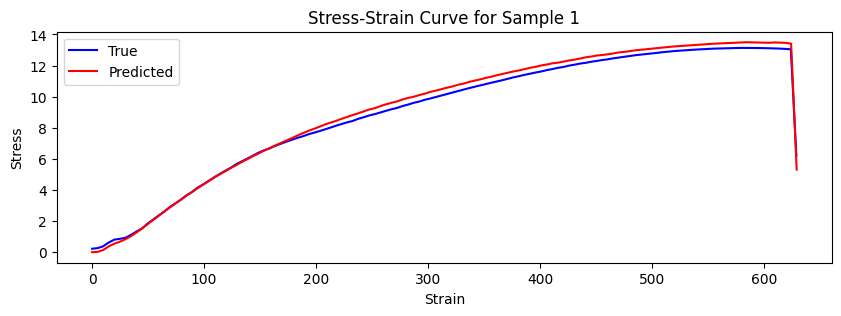

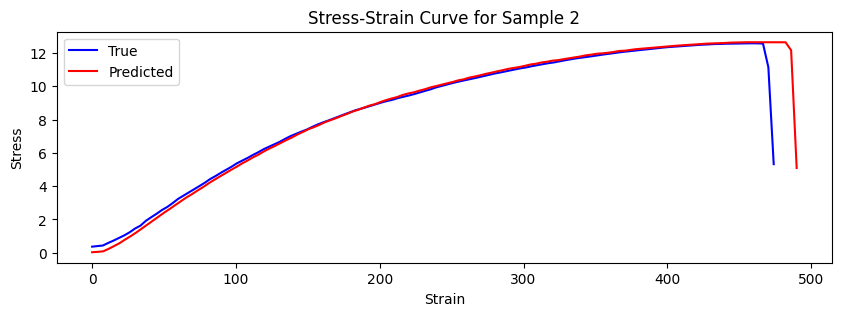

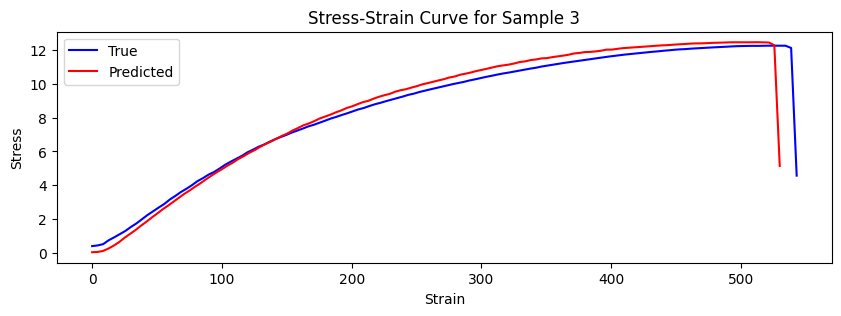

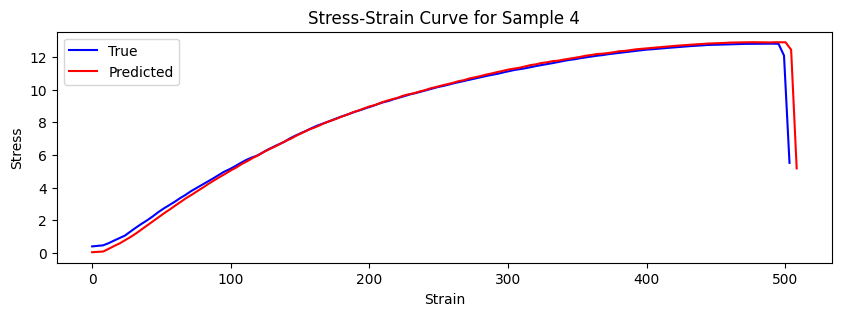

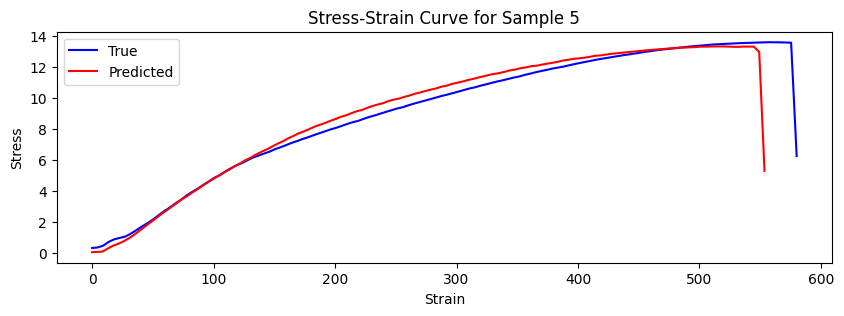

In [19]:
import matplotlib.pyplot as plt

# Plotting the true and predicted stress-strain curves
for i in range(n):
    plt.figure(figsize=(10, 3))

    # Plotting the true curve
    plt.plot(
        strain_true[i, :, 0],
        stress_true[i, :, 0],
        label="True",
        color="blue",
    )

    # Plotting the predicted curve
    plt.plot(
        strain_pred[i, :, 0],
        stress_pred[i, :, 0],
        label="Predicted",
        color="red",
    )

    plt.xlabel("Strain")
    plt.ylabel("Stress")
    plt.title(f"Stress-Strain Curve for Sample {i+1}")
    plt.legend()
    plt.show()